In [1]:
!pip install category_encoders shap xgboost scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, roc_curve, precision_score, recall_score, make_scorer
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier

import warnings
import shap
import category_encoders as ce

from scipy.stats import chi2_contingency


In [3]:
data = pd.read_csv('HR_comma_sep.csv')

In [4]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
data.shape

(14999, 10)

In [6]:
data.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [7]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [8]:
data.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [9]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


<AxesSubplot: >

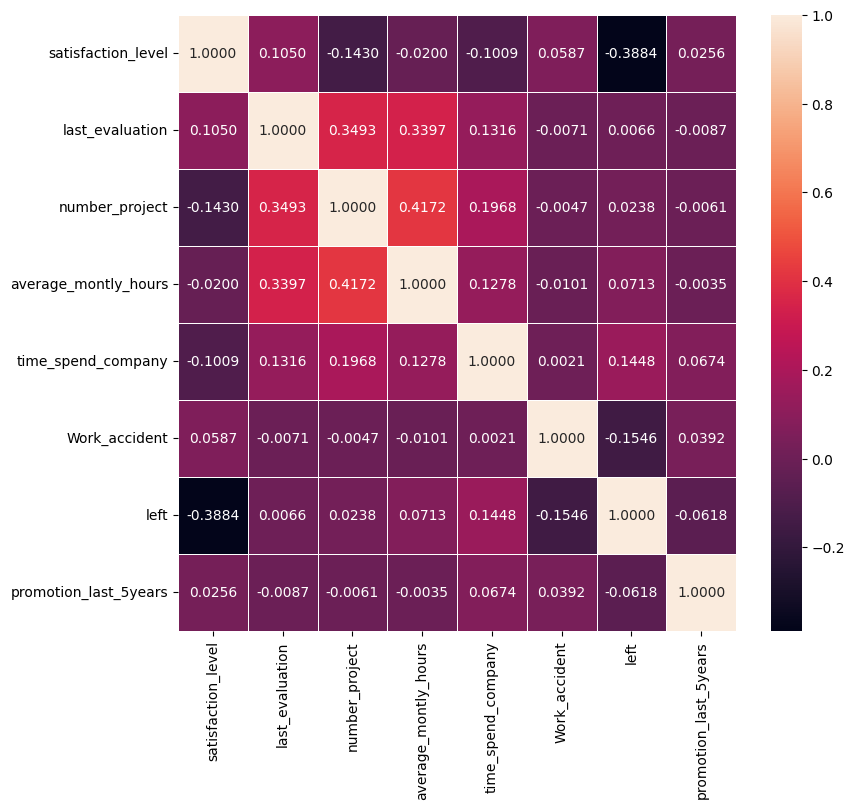

In [10]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(data.drop(columns=['sales', 'salary']).corr(), annot=True, linewidths=.5, fmt= '.4f', ax=ax)

# Exploratory Data Analysis

### salary

In [11]:
data[['salary', 'left']].groupby(['salary'], as_index=False).mean().sort_values(by='left', ascending=False)


,salary,left
1,low,0.296884
2,medium,0.204313
0,high,0.066289


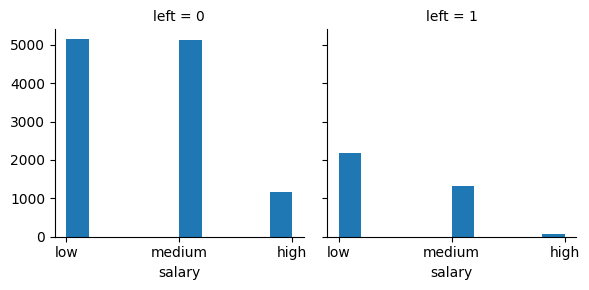

In [12]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'salary')

In [13]:
pivot = pd.crosstab(data.left, data.salary)
pivot

salary,high,low,medium
left,,,
0,1155,5144,5129
1,82,2172,1317


In [14]:
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)

p-value is 0.0000


### sales

In [15]:
data[['sales', 'left']].groupby(['sales'], as_index=False).mean().sort_values(by='left', ascending=False)

,sales,left
3,hr,0.290934
2,accounting,0.265971
9,technical,0.256250
8,support,0.248991
7,sales,0.244928
5,marketing,0.236597
0,IT,0.222494
6,product_mng,0.219512
1,RandD,0.153748
4,management,0.144444


In [16]:
pivot = pd.crosstab(data.left, data.sales)
pivot

sales,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
left,,,,,,,,,,
0,954,666,563,524,539,655,704,3126,1674,2023
1,273,121,204,215,91,203,198,1014,555,697


In [17]:
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)

p-value is 0.0000


### satisfaction_level

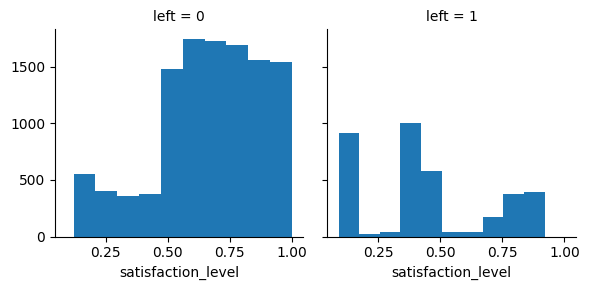

In [18]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'satisfaction_level', bins=10)

In [19]:
data['satisfaction_level_test'] = data['satisfaction_level'].apply(lambda x: int(x / 0.2))

pivot = pd.crosstab(data.left, data.satisfaction_level_test)
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)
data = data.drop(columns=['satisfaction_level_test'])

p-value is 0.0000


### last_evaluation

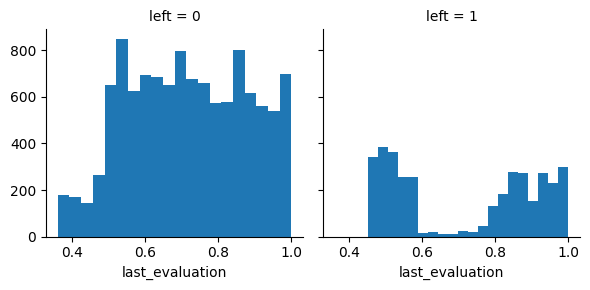

In [20]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'last_evaluation', bins=20)

In [21]:
data['last_evaluation_test'] = data['last_evaluation'].apply(lambda x: int(x / 0.2))

pivot = pd.crosstab(data.left, data.last_evaluation)
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)
data = data.drop(columns=['last_evaluation_test'])

p-value is 0.0000


### number_project

In [22]:
data[['number_project', 'left']].groupby(['number_project'], as_index=False).mean().sort_values(by='number_project', ascending=False)


,number_project,left
5,7,1.000000
4,6,0.557922
3,5,0.221659
2,4,0.093700
1,3,0.017756
0,2,0.656198


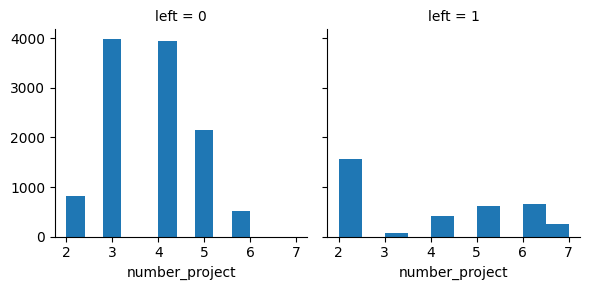

In [23]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'number_project')

In [24]:
pivot = pd.crosstab(data.left, data.number_project)
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)

p-value is 0.0000


### average_montly_hours

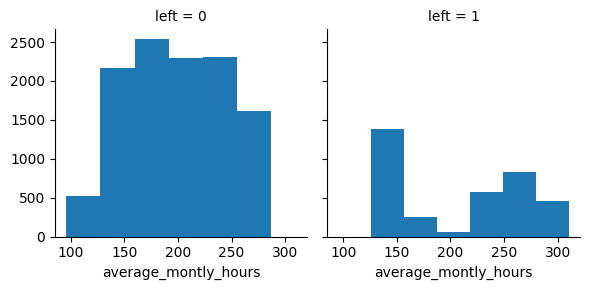

In [25]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'average_montly_hours', bins=6)

In [26]:
data['average_montly_hours_test'] = data['average_montly_hours'].apply(lambda x: int(x / 50))

pivot = pd.crosstab(data.left, data.average_montly_hours_test)
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)
data = data.drop(columns=['average_montly_hours_test'])

p-value is 0.0000


### time_spend_company

In [27]:
data[['time_spend_company', 'left']].groupby(['time_spend_company'], as_index=False).mean().sort_values(by='left', ascending=False)


,time_spend_company,left
3,5,0.565513
2,4,0.348064
4,6,0.291086
1,3,0.246159
0,2,0.016338
5,7,0.000000
6,8,0.000000
7,10,0.000000


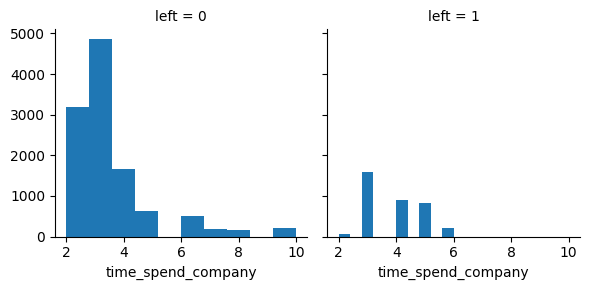

In [28]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'time_spend_company')

In [29]:
pivot = pd.crosstab(data.left, data.time_spend_company)
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)

p-value is 0.0000


### Work_accident

In [30]:
data[['Work_accident', 'left']].groupby(['Work_accident'], as_index=False).mean().sort_values(by='left', ascending=False)


,Work_accident,left
0,0,0.265160
1,1,0.077916


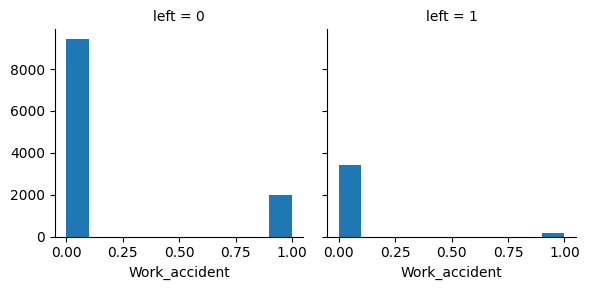

In [31]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'Work_accident')

In [32]:
pivot = pd.crosstab(data.left, data.Work_accident)
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)

p-value is 0.0000


### promotion_last_5years

In [33]:
data[['promotion_last_5years', 'left']].groupby(['promotion_last_5years'], as_index=False).mean().sort_values(by='left', ascending=False)


,promotion_last_5years,left
0,0,0.241962
1,1,0.059561


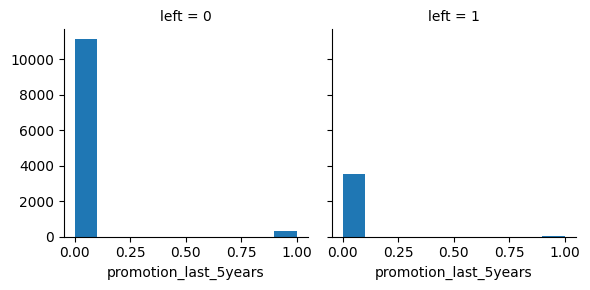

In [34]:
g = sns.FacetGrid(data, col='left')
g.map(plt.hist, 'promotion_last_5years')

In [35]:
pivot = pd.crosstab(data.left, data.promotion_last_5years)
g, p, dof, expctd = chi2_contingency(pivot)
print("p-value is %.4f" % p)

p-value is 0.0000


# Data Preprocessing

## encoding

In [36]:
data['salary'] = data['salary'].map({'high': 0, 'medium': 1, 'low': 2} ).astype(int)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,2
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,2
4,0.37,0.52,2,159,3,0,1,0,sales,2


In [37]:
data = pd.get_dummies(data)

In [38]:
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,2,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,2,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,2,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,2,0,0,0,0,0,0,0,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,2,0,0,0,0,0,0,0,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,2,0,0,0,0,0,0,0,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,2,0,0,0,0,0,0,0,0,1,0


# Model Build up

## Baseline

### Define training set and test set

In [39]:
X, y = data.drop(columns=['left']), data['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Compare common ML models

In [40]:
models = {
    'XGBoost': XGBClassifier(),
    'GBDT': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

In [41]:
for model_name, classifier in models.items():
    model = classifier
    model.fit(X_train, y_train)
    print("%s: %.4f" % (model_name, cross_val_score(model, X_train, y_train, cv=5).mean()))

XGBoost: 0.9876
GBDT: 0.9766
Random Forest: 0.9906
AdaBoost: 0.9602
Extra Trees: 0.9866
Decision Tree: 0.9782


### Test best model

In [42]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("Training Set:")
print("Random Forest: %.4f" % rf.score(X_train, y_train))
print("Summary\n", metrics.classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print('\n')
print("Test Set:")
print("Random Forest: %.4f" % rf.score(X_test, y_test))
print("Summary\n", metrics.classification_report(y_test, y_pred))
matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)
print("Test Set recall: %.5f" % (matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])))

Training Set:
Random Forest: 1.0000
Summary
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999

Confusion Matrix:
 [[9142    0]
 [   0 2857]]


Test Set:
Random Forest: 0.9903
Summary
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
 [[2283    3]
 [  26  688]]
Test Set recall: 0.96359


In [43]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

print("Training Set:")
print("Xgboost: %.4f" % xgb.score(X_train, y_train))
print("Summary\n", metrics.classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print('\n')
print("Test Set:")
print("Xgboost: %.4f" % xgb.score(X_test, y_test))
print("Summary\n", metrics.classification_report(y_test, y_pred))
matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)
print("Test Set recall: %.5f" % (matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])))

Training Set:
Xgboost: 0.9977
Summary
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      0.99      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999

Confusion Matrix:
 [[9135    7]
 [  21 2836]]


Test Set:
Xgboost: 0.9883
Summary
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
 [[2276   10]
 [  25  689]]
Test Set recall: 0.96499


## Model optimization

### hyperparameters tuning

In [44]:
# Random Forest
param_grid = {
    'n_estimators': np.arange(100, 301, 20),
    'min_samples_split': [2, 5, 10],
    "min_samples_leaf": np.arange(1, 20, 2),
    'max_depth': [3, 5, 7],
    'max_features': [3, 5, 10, 20],
    'bootstrap': [True, False]       
}

rs_model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42),
                              param_distributions = param_grid,
                              n_iter = 5,
                              cv = 5,
                              verbose = True,
                              refit='recall')


rs_model.fit(X_train, y_train)

y_train_pred = rs_model.predict(X_train)

y_test_pred = rs_model.predict(X_test)

print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))


final_model = rs_model.best_estimator_
print('Optimized hyperparametere', rs_model.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9142
           1       0.96      0.93      0.95      2857

    accuracy                           0.98     11999
   macro avg       0.97      0.96      0.97     11999
weighted avg       0.98      0.98      0.98     11999

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2286
           1       0.96      0.94      0.95       714

    accuracy                           0.98      3000
   macro avg       0.97      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000

Optimized hyperparametere {'n_estimators': 160, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 20, 'max_depth': 5, 'bootstrap': False}


In [45]:
rf = RandomForestClassifier(**rs_model.best_params_)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("Training Set:")
print("Random Forest: %.4f" % rf.score(X_train, y_train))
print("Summary\n", metrics.classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print('\n')
print("Test Set:")
print("Random Forest: %.4f" % rf.score(X_test, y_test))
print("Summary\n", metrics.classification_report(y_test, y_pred))
matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)
print("Test Set recall: %.5f" % (matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])))

Training Set:
Random Forest: 0.9754
Summary
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      9142
           1       0.96      0.93      0.95      2857

    accuracy                           0.98     11999
   macro avg       0.97      0.96      0.97     11999
weighted avg       0.98      0.98      0.98     11999

Confusion Matrix:
 [[9044   98]
 [ 197 2660]]


Test Set:
Random Forest: 0.9753
Summary
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2286
           1       0.96      0.94      0.95       714

    accuracy                           0.98      3000
   macro avg       0.97      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000

Confusion Matrix:
 [[2258   28]
 [  46  668]]
Test Set recall: 0.93557


In [46]:
# no improvement

In [47]:
# XGBoost
grids = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1e-5,
    'reg_lambda': 1
}

def tune_lr(X, y, grids, cv=5, learning_rate_grid = [0.01, 0.015, 0.025, 0.05, 0.1]):
    param_test0 = {
        'learning_rate': learning_rate_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test0,
        scoring = 'recall',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['learning_rate'] = gsearch.best_params_['learning_rate']
    
def tune_depth_weight(X, y, grids, cv=5, max_depth_grid=[i for i in range(3, 10, 2)], min_child_weight_grid=[i for i in range(1, 6, 2)]):
    param_test1 = {
        'max_depth': max_depth_grid,
        'min_child_weight': min_child_weight_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test1,
        scoring = 'recall',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['max_depth'] = gsearch.best_params_['max_depth']
    grids['min_child_weight'] = gsearch.best_params_['min_child_weight']
    
def tune_gamma(X, y, grids, cv=5, gamma_grid=[i/10.0 for i in range(0, 5)]):
    param_test2 = {
        'gamma': gamma_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test2,
        scoring = 'recall',
        n_jobs = 4,
        cv = cv
    )
    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['gamma'] = gsearch.best_params_['gamma']
    
def tune_sample(X, y, grids, cv=5, subsample_grid=[i/10.0 for i in range(6, 10)], colsample_grid=[i/10.0 for i in range(6, 10)]):
    param_test3 = {
        'subsample': subsample_grid,
        'colsample_bytree': colsample_grid
    }
    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test3,
        scoring = 'recall',
        n_jobs = 4,
        cv = cv
    )
    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['subsample'] = gsearch.best_params_['subsample']
    grids['colsample_bytree'] = gsearch.best_params_['colsample_bytree']
    
def tune_alpha(X, y, grids, cv=5, alpha_grid=[1e-5, 1e-2, 0.1, 1, 100]):
    param_test4 = {
        'reg_alpha': alpha_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),

        param_grid = param_test4,
        scoring = 'recall',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['reg_alpha'] = gsearch.best_params_['reg_alpha']
    
def tune_lambda(X, y, grids, cv=5, lambda_grid=[1e-5, 1e-2, 0.1, 1, 100]):
    param_test5 = {
        'reg_lambda': lambda_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),

        param_grid = param_test5,
        scoring = 'recall',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X_train, y_train)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['reg_lambda'] = gsearch.best_params_['reg_lambda']
    
def tune_XGBoost(X, y, CV=5):
    
    grids = {
        'learning_rate': 0.1,
        'max_depth': 5,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1e-5,
        'reg_lambda': 1
    }
    
    tune_lr(X, y, grids, cv=CV)
    tune_depth_weight(X, y, grids, cv=CV)

    tune_gamma(X, y, grids, cv=CV)
    tune_sample(X, y, grids, cv=CV)
    tune_alpha(X, y, grids, cv=CV)
    tune_lambda(X, y, grids, cv=CV)
    
    return grids

In [48]:
grids = tune_XGBoost(X_train, y_train, CV=5)
    
xgb_classifier = XGBClassifier(
    n_estimators = 400, 
    **grids,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = 1,
    seed = 42
)

xgb_classifier.fit(X_train, y_train)

y_train_pred = xgb_classifier.predict(X_train)
y_pred = xgb_classifier.predict(X_test)

{'learning_rate': 0.1}
0.9341928649284166
{'max_depth': 9, 'min_child_weight': 1}
0.9600994452132806
{'gamma': 0.1}
0.9611490086096041
{'colsample_bytree': 0.9, 'subsample': 0.9}
0.9632493600969958
{'reg_alpha': 1e-05}
0.9632493600969958
{'reg_lambda': 0.01}
0.96850146351022


In [49]:
print("Training Set:")
print("Xgboost: %.4f" % xgb_classifier.score(X_train, y_train))
print("Summary\n", metrics.classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print('\n')
print("Test Set:")
print("Xgboost: %.4f" % xgb_classifier.score(X_test, y_test))
print("Summary\n", metrics.classification_report(y_test, y_pred))
matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)
print("Test Set recall: %.5f" % (matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])))

Training Set:
Xgboost: 1.0000
Summary
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999

Confusion Matrix:
 [[9142    0]
 [   0 2857]]


Test Set:
Xgboost: 0.9890
Summary
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.98      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
 [[2275   11]
 [  22  692]]
Test Set recall: 0.96919


### encoding optimization

In [50]:
data = pd.read_csv('HR_comma_sep.csv')

In [51]:
data['salary'] = data['salary'].map({'high': 0, 'medium': 1, 'low': 2} ).astype(int)

In [52]:
woe_encoder = ce.WOEEncoder(cols='sales')
woe_encoded_train = woe_encoder.fit_transform(data['sales'], data['left']).add_suffix('_woe')
data = data.join(woe_encoded_train)
data = data.drop(columns=['sales'])

In [53]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales_woe
0,0.38,0.53,2,157,3,0,1,0,2,0.03765
1,0.80,0.86,5,262,6,0,1,0,1,0.03765
2,0.11,0.88,7,272,4,0,1,0,1,0.03765
3,0.72,0.87,5,223,5,0,1,0,2,0.03765
4,0.37,0.52,2,159,3,0,1,0,2,0.03765


In [54]:
data.shape

(14999, 10)

In [55]:
# X, y = data.drop(columns=['left', 'average_montly_hours', 'number_project']), data['left']
X, y = data.drop(columns=['left']), data['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### test model

In [56]:
# random forest

In [57]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_pred = rf.predict(X_test)

print("Training Set:")
print("Random Forest: %.4f" % rf.score(X_train, y_train))
print("Summary\n", metrics.classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print('\n')
print("Test Set:")
print("Random Forest: %.4f" % rf.score(X_test, y_test))
print("Summary\n", metrics.classification_report(y_test, y_pred))
matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)
print("Test Set recall: %.5f" % (matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])))

Training Set:
Random Forest: 1.0000
Summary
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999

Confusion Matrix:
 [[9142    0]
 [   0 2857]]


Test Set:
Random Forest: 0.9910
Summary
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
 [[2283    3]
 [  24  690]]
Test Set recall: 0.96639


In [58]:
# XGBoost

In [59]:
xgb_classifier = XGBClassifier(
    n_estimators = 400, 
    **grids,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = 1,
    seed = 42
)

xgb_classifier.fit(X_train, y_train)

y_train_pred = xgb_classifier.predict(X_train)
y_pred = xgb_classifier.predict(X_test)

In [60]:
print("Training Set:")
print("Xgboost: %.4f" % xgb_classifier.score(X_train, y_train))
print("Summary\n", metrics.classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print('\n')
print("Test Set:")
print("Xgboost: %.4f" % xgb_classifier.score(X_test, y_test))
print("Summary\n", metrics.classification_report(y_test, y_pred))
matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)
print("Test Set recall: %.5f" % (matrix[1, 1] / (matrix[1, 0] + matrix[1, 1])))

Training Set:
Xgboost: 1.0000
Summary
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999

Confusion Matrix:
 [[9142    0]
 [   0 2857]]


Test Set:
Xgboost: 0.9887
Summary
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
 [[2274   12]
 [  22  692]]
Test Set recall: 0.96919


## Feature importances

### explained using XGBoost

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

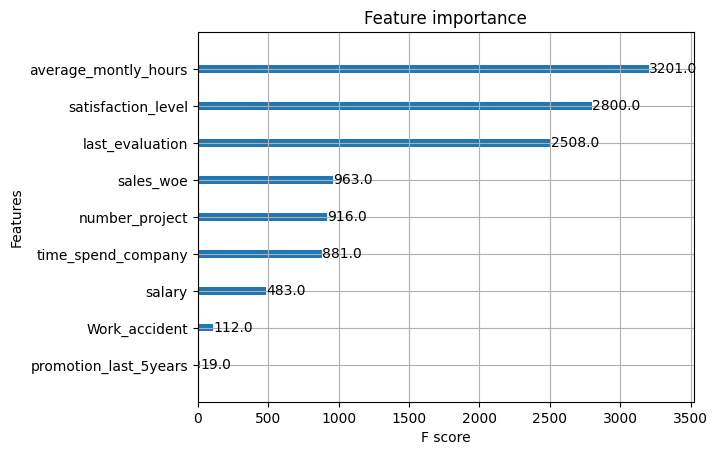

In [61]:
plot_importance(xgb_classifier)

In [62]:
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


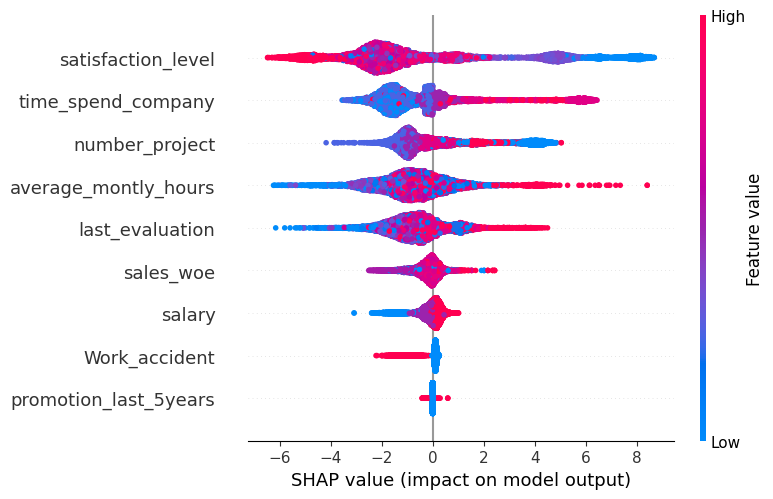

In [63]:
shap.summary_plot(shap_values, X_train, plot_type='dot')

### explained using Random Forest

In [64]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

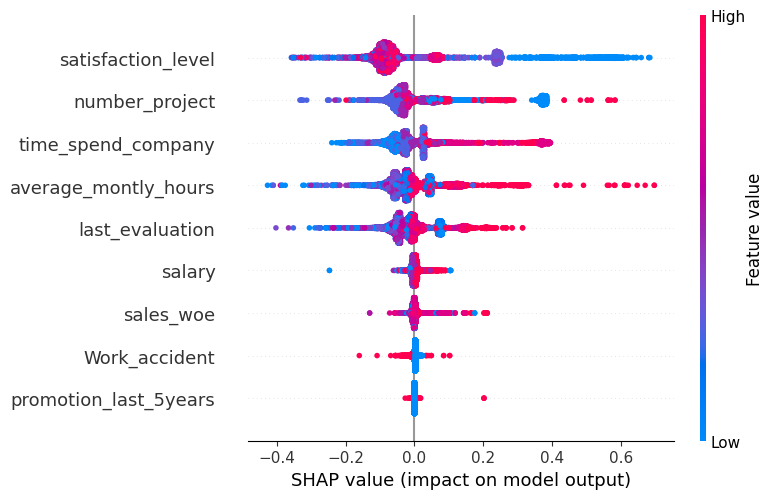

In [65]:
shap.summary_plot(shap_values[1], X_train, plot_type='dot')


In [66]:
rf.feature_importances_

array([0.32495224, 0.11999101, 0.1816339 , 0.15153627, 0.19595325,
       0.00459356, 0.00076346, 0.00806915, 0.01250717])

In [67]:
feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

satisfaction_level       0.324952
time_spend_company       0.195953
number_project           0.181634
average_montly_hours     0.151536
last_evaluation          0.119991
sales_woe                0.012507
salary                   0.008069
Work_accident            0.004594
promotion_last_5years    0.000763
dtype: float64

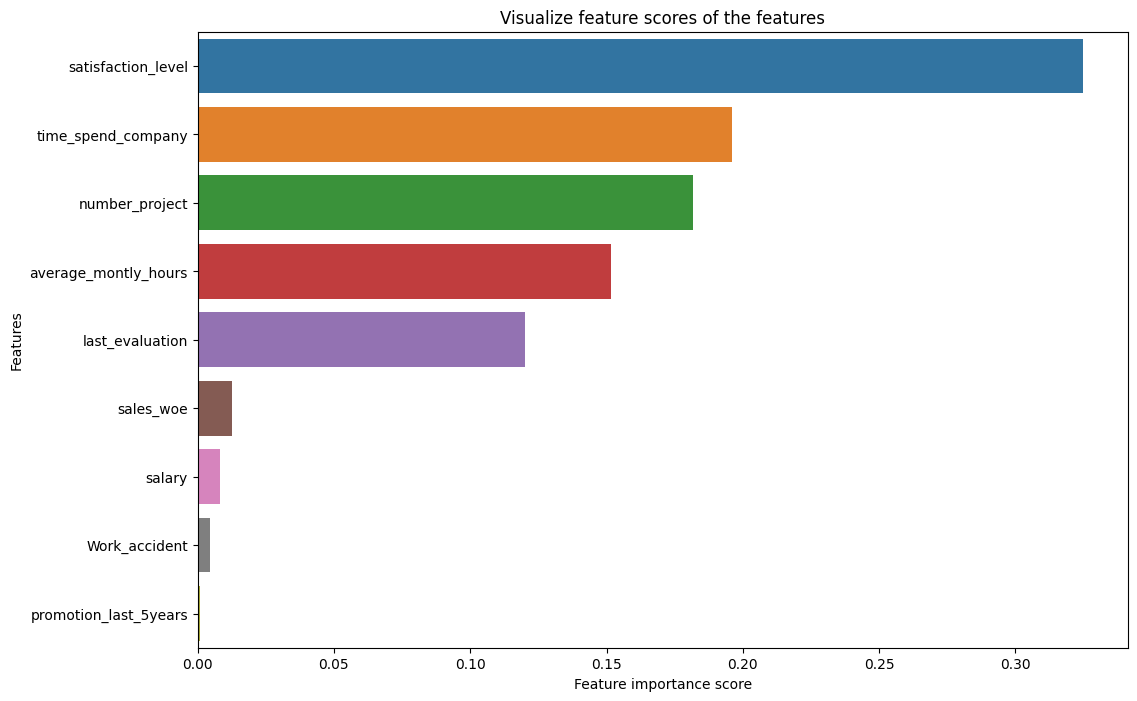

In [68]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

# Conclusion

1. correlations are all significant based on Chi-square test

Further improvement
1. more encoding
2. deal with imbalance dataset
3. interpretability and model performance trade-off, drop one feature, eg average_monthly_hours, model performance
drops; adding more features, performance increases while correlated variables can't be interpreted.